##### Copyright 2020 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# TF Lattice 사전 제작 모델

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://www.tensorflow.org/lattice/tutorials/premade_models"><img src="https://www.tensorflow.org/images/tf_logo_32px.png">TensorFlow.org에서 보기</a></td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ko/lattice/tutorials/premade_models.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Google Colab에서 실행하기</a></td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ko/lattice/tutorials/premade_models.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">GitHub에서 소스 보기</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ko/lattice/tutorials/premade_models.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">노트북 다운로드하기</a></td>
</table>

## 개요

사전 제작된 모델은 일반적인 사용 사례를 위해 TFL `tf.keras.model` 인스턴스를 구축하는 빠르고 쉬운 방법입니다. 이 가이드에서는 TFL 사전 제작 모델을 구성하고 훈련/테스트하는 데 필요한 단계를 설명합니다. 

## 설정

TF Lattice 패키지 설치하기

In [2]:
#@test {"skip": true}
!pip install tensorflow-lattice pydot

  Using cached tensorflow_lattice-2.0.9-py2.py3-none-any.whl (235 kB)


  Using cached dm_sonnet-2.0.0-py3-none-any.whl (254 kB)


  Using cached graphviz-0.17-py3-none-any.whl (18 kB)


  Using cached tabulate-0.8.9-py3-none-any.whl (25 kB)


  Using cached dm_tree-0.1.6-cp37-cp37m-manylinux_2_24_x86_64.whl (93 kB)


필수 패키지 가져오기

In [3]:
import tensorflow as tf

import copy
import logging
import numpy as np
import pandas as pd
import sys
import tensorflow_lattice as tfl
logging.disable(sys.maxsize)

UCI Statlog(Heart) 데이터세트 다운로드하기

In [4]:
csv_file = tf.keras.utils.get_file(
    'heart.csv', 'http://storage.googleapis.com/download.tensorflow.org/data/heart.csv')
df = pd.read_csv(csv_file)
train_size = int(len(df) * 0.8)
train_dataframe = df[:train_size]
test_dataframe = df[train_size:]
df.head()

age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   63    1   1       145   233    1        2      150      0      2.3      3   
1   67    1   4       160   286    0        2      108      1      1.5      2   
2   67    1   4       120   229    0        2      129      1      2.6      2   
3   37    1   3       130   250    0        0      187      0      3.5      3   
4   41    0   2       130   204    0        2      172      0      1.4      1   

   ca        thal  target  
0   0       fixed       0  
1   3      normal       1  
2   2  reversible       0  
3   0      normal       0  
4   0      normal       0

특성과 레이블을 추출하고 텐서로 변환합니다.

In [5]:
# Features:
# - age
# - sex
# - cp        chest pain type (4 values)
# - trestbps  resting blood pressure
# - chol      serum cholestoral in mg/dl
# - fbs       fasting blood sugar > 120 mg/dl
# - restecg   resting electrocardiographic results (values 0,1,2)
# - thalach   maximum heart rate achieved
# - exang     exercise induced angina
# - oldpeak   ST depression induced by exercise relative to rest
# - slope     the slope of the peak exercise ST segment
# - ca        number of major vessels (0-3) colored by flourosopy
# - thal      3 = normal; 6 = fixed defect; 7 = reversable defect
#
# This ordering of feature names will be the exact same order that we construct
# our model to expect.
feature_names = [
    'age', 'sex', 'cp', 'chol', 'fbs', 'trestbps', 'thalach', 'restecg',
    'exang', 'oldpeak', 'slope', 'ca', 'thal'
]
feature_name_indices = {name: index for index, name in enumerate(feature_names)}
# This is the vocab list and mapping we will use for the 'thal' categorical
# feature.
thal_vocab_list = ['normal', 'fixed', 'reversible']
thal_map = {category: i for i, category in enumerate(thal_vocab_list)}

In [6]:
# Custom function for converting thal categories to buckets
def convert_thal_features(thal_features):
  # Note that two examples in the test set are already converted.
  return np.array([
      thal_map[feature] if feature in thal_vocab_list else feature
      for feature in thal_features
  ])


# Custom function for extracting each feature.
def extract_features(dataframe,
                     label_name='target',
                     feature_names=feature_names):
  features = []
  for feature_name in feature_names:
    if feature_name == 'thal':
      features.append(
          convert_thal_features(dataframe[feature_name].values).astype(float))
    else:
      features.append(dataframe[feature_name].values.astype(float))
  labels = dataframe[label_name].values.astype(float)
  return features, labels

In [7]:
train_xs, train_ys = extract_features(train_dataframe)
test_xs, test_ys = extract_features(test_dataframe)

In [8]:
# Let's define our label minimum and maximum.
min_label, max_label = float(np.min(train_ys)), float(np.max(train_ys))
# Our lattice models may have predictions above 1.0 due to numerical errors.
# We can subtract this small epsilon value from our output_max to make sure we
# do not predict values outside of our label bound.
numerical_error_epsilon = 1e-5

이 가이드에서 훈련에 사용되는 기본값 설정하기

In [9]:
LEARNING_RATE = 0.01
BATCH_SIZE = 128
NUM_EPOCHS = 500
PREFITTING_NUM_EPOCHS = 10

## 특성 구성

특성 보정 및 특성별 구성은 [tfl.configs.FeatureConfig](https://www.tensorflow.org/lattice/api_docs/python/tfl/configs/FeatureConfig)를 사용하여 설정됩니다. 특성 구성에는 단조 제약 조건, 특성별 정규화([tfl.configs.RegularizerConfig](https://www.tensorflow.org/lattice/api_docs/python/tfl/configs/RegularizerConfig) 참조) 및 격자 모델에 대한 격자 크기가 포함됩니다.

모델이 인식해야 할 모든 특성에 대한 특성 구성을 완전하게 지정해야합니다. 그렇지 않으면 모델은 이러한 특성이 존재하는지 알 수 없습니다.

### 분위수 계산하기

`tfl.configs.FeatureConfig`에서 `pwl_calibration_input_keypoints`의 기본 설정은 'quantiles'이지만 사전 제작된 모델의 경우 입력 키포인트를 수동으로 정의해야 합니다. 이를 위해 먼저 분위수 계산을 위한 자체 도우미 함수를 정의합니다. 

In [10]:
def compute_quantiles(features,
                      num_keypoints=10,
                      clip_min=None,
                      clip_max=None,
                      missing_value=None):
  # Clip min and max if desired.
  if clip_min is not None:
    features = np.maximum(features, clip_min)
    features = np.append(features, clip_min)
  if clip_max is not None:
    features = np.minimum(features, clip_max)
    features = np.append(features, clip_max)
  # Make features unique.
  unique_features = np.unique(features)
  # Remove missing values if specified.
  if missing_value is not None:
    unique_features = np.delete(unique_features,
                                np.where(unique_features == missing_value))
  # Compute and return quantiles over unique non-missing feature values.
  return np.quantile(
      unique_features,
      np.linspace(0., 1., num=num_keypoints),
      interpolation='nearest').astype(float)

### 특성 구성 정의하기

이제 분위수를 계산할 수 있으므로 모델이 입력으로 사용하기 원하는 각 특성에 대한 특성 구성을 정의합니다.

In [11]:
# Feature configs are used to specify how each feature is calibrated and used.
feature_configs = [
    tfl.configs.FeatureConfig(
        name='age',
        lattice_size=3,
        monotonicity='increasing',
        # We must set the keypoints manually.
        pwl_calibration_num_keypoints=5,
        pwl_calibration_input_keypoints=compute_quantiles(
            train_xs[feature_name_indices['age']],
            num_keypoints=5,
            clip_max=100),
        # Per feature regularization.
        regularizer_configs=[
            tfl.configs.RegularizerConfig(name='calib_wrinkle', l2=0.1),
        ],
    ),
    tfl.configs.FeatureConfig(
        name='sex',
        num_buckets=2,
    ),
    tfl.configs.FeatureConfig(
        name='cp',
        monotonicity='increasing',
        # Keypoints that are uniformly spaced.
        pwl_calibration_num_keypoints=4,
        pwl_calibration_input_keypoints=np.linspace(
            np.min(train_xs[feature_name_indices['cp']]),
            np.max(train_xs[feature_name_indices['cp']]),
            num=4),
    ),
    tfl.configs.FeatureConfig(
        name='chol',
        monotonicity='increasing',
        # Explicit input keypoints initialization.
        pwl_calibration_input_keypoints=[126.0, 210.0, 247.0, 286.0, 564.0],
        # Calibration can be forced to span the full output range by clamping.
        pwl_calibration_clamp_min=True,
        pwl_calibration_clamp_max=True,
        # Per feature regularization.
        regularizer_configs=[
            tfl.configs.RegularizerConfig(name='calib_hessian', l2=1e-4),
        ],
    ),
    tfl.configs.FeatureConfig(
        name='fbs',
        # Partial monotonicity: output(0) <= output(1)
        monotonicity=[(0, 1)],
        num_buckets=2,
    ),
    tfl.configs.FeatureConfig(
        name='trestbps',
        monotonicity='decreasing',
        pwl_calibration_num_keypoints=5,
        pwl_calibration_input_keypoints=compute_quantiles(
            train_xs[feature_name_indices['trestbps']], num_keypoints=5),
    ),
    tfl.configs.FeatureConfig(
        name='thalach',
        monotonicity='decreasing',
        pwl_calibration_num_keypoints=5,
        pwl_calibration_input_keypoints=compute_quantiles(
            train_xs[feature_name_indices['thalach']], num_keypoints=5),
    ),
    tfl.configs.FeatureConfig(
        name='restecg',
        # Partial monotonicity: output(0) <= output(1), output(0) <= output(2)
        monotonicity=[(0, 1), (0, 2)],
        num_buckets=3,
    ),
    tfl.configs.FeatureConfig(
        name='exang',
        # Partial monotonicity: output(0) <= output(1)
        monotonicity=[(0, 1)],
        num_buckets=2,
    ),
    tfl.configs.FeatureConfig(
        name='oldpeak',
        monotonicity='increasing',
        pwl_calibration_num_keypoints=5,
        pwl_calibration_input_keypoints=compute_quantiles(
            train_xs[feature_name_indices['oldpeak']], num_keypoints=5),
    ),
    tfl.configs.FeatureConfig(
        name='slope',
        # Partial monotonicity: output(0) <= output(1), output(1) <= output(2)
        monotonicity=[(0, 1), (1, 2)],
        num_buckets=3,
    ),
    tfl.configs.FeatureConfig(
        name='ca',
        monotonicity='increasing',
        pwl_calibration_num_keypoints=4,
        pwl_calibration_input_keypoints=compute_quantiles(
            train_xs[feature_name_indices['ca']], num_keypoints=4),
    ),
    tfl.configs.FeatureConfig(
        name='thal',
        # Partial monotonicity:
        # output(normal) <= output(fixed)
        # output(normal) <= output(reversible)
        monotonicity=[('normal', 'fixed'), ('normal', 'reversible')],
        num_buckets=3,
        # We must specify the vocabulary list in order to later set the
        # monotonicities since we used names and not indices.
        vocabulary_list=thal_vocab_list,
    ),
]

다음으로 사용자 정의 어휘(위의 'thal'과 같은)를 사용한 특성에 대해 단조를 올바르게 설정해야합니다.

In [12]:
tfl.premade_lib.set_categorical_monotonicities(feature_configs)

## 보정된 선형 모델

TFL 사전 제작 모델을 구성하려면 먼저 [tfl.configs](https://www.tensorflow.org/lattice/api_docs/python/tfl/configs)에서 모델 구성을 갖추세요. 보정된 선형 모델은 [tfl.configs.CalibratedLinearConfig](https://www.tensorflow.org/lattice/api_docs/python/tfl/configs/CalibratedLinearConfig)를 사용하여 구성됩니다. 입력 특성에 구간 선형 및 범주형 보정을 적용한 다음 선형 조합 및 선택적 출력 구간 선형 보정을 적용합니다. 출력 보정을 사용하거나 출력 경계가 지정된 경우 선형 레이어는 보정된 입력에 가중치 평균을 적용합니다.

이 예제는 처음 5개 특성에 대해 보정된 선형 모델을 만듭니다.

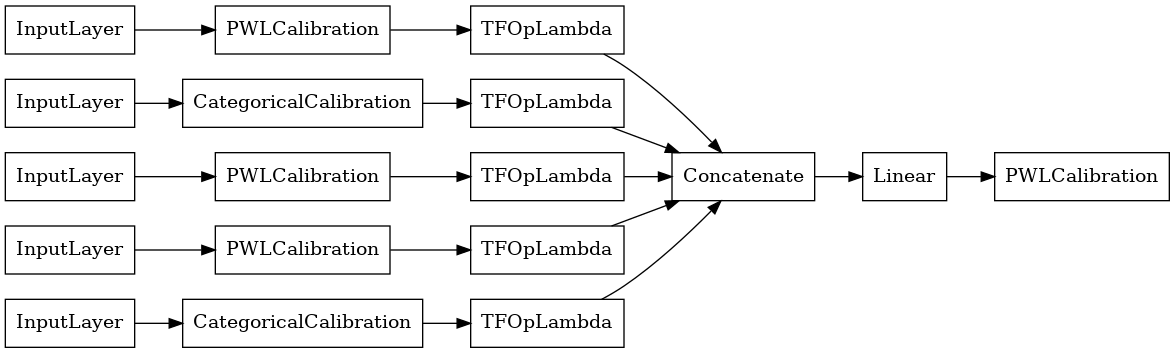

In [13]:
# Model config defines the model structure for the premade model.
linear_model_config = tfl.configs.CalibratedLinearConfig(
    feature_configs=feature_configs[:5],
    use_bias=True,
    # We must set the output min and max to that of the label.
    output_min=min_label,
    output_max=max_label,
    output_calibration=True,
    output_calibration_num_keypoints=10,
    output_initialization=np.linspace(min_label, max_label, num=10),
    regularizer_configs=[
        # Regularizer for the output calibrator.
        tfl.configs.RegularizerConfig(name='output_calib_hessian', l2=1e-4),
    ])
# A CalibratedLinear premade model constructed from the given model config.
linear_model = tfl.premade.CalibratedLinear(linear_model_config)
# Let's plot our model.
tf.keras.utils.plot_model(linear_model, show_layer_names=False, rankdir='LR')

이제 다른 [tf.keras.Model](https://www.tensorflow.org/api_docs/python/tf/keras/Model)과 마찬가지로 모델을 데이터에 맞게 컴파일하고 적합하도록 맞춥니다.

In [14]:
linear_model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.AUC()],
    optimizer=tf.keras.optimizers.Adam(LEARNING_RATE))
linear_model.fit(
    train_xs[:5],
    train_ys,
    epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=False)

모델을 훈련한 후 테스트세트에서 평가할 수 있습니다.

In [15]:
print('Test Set Evaluation...')
print(linear_model.evaluate(test_xs[:5], test_ys))

Test Set Evaluation...


1/2 [==============>...............] - ETA: 0s - loss: 0.3446 - auc: 0.8397

2/2 [==============================] - 0s 4ms/step - loss: 0.4673 - auc: 0.8358


[0.467307984828949, 0.8358396291732788]


## 보정된 격자 모델

보정된 격자 모델은 [tfl.configs.CalibratedLatticeConfig](https://www.tensorflow.org/lattice/api_docs/python/tfl/configs/CalibratedLatticeConfig)를 사용하여 구성됩니다. 보정된 격자 모델은 입력 특성에 구간별 선형 및 범주형 보정을 적용한 다음 격자 모델 및 선택적 출력 구간별 선형 보정을 적용합니다.

이 예제에서는 처음 5개의 특성에 대해 보정된 격자 모델을 만듭니다.

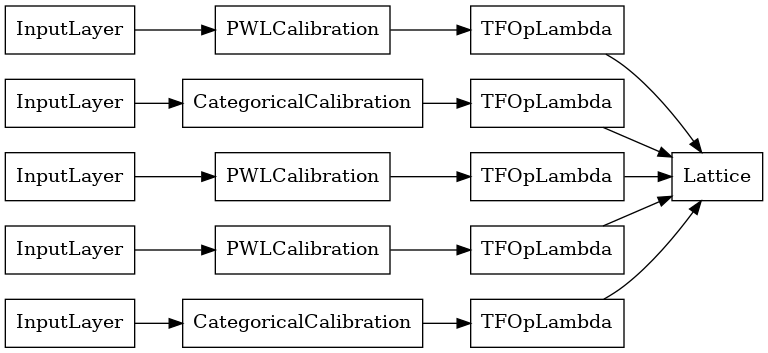

In [16]:
# This is a calibrated lattice model: inputs are calibrated, then combined
# non-linearly using a lattice layer.
lattice_model_config = tfl.configs.CalibratedLatticeConfig(
    feature_configs=feature_configs[:5],
    output_min=min_label,
    output_max=max_label - numerical_error_epsilon,
    output_initialization=[min_label, max_label],
    regularizer_configs=[
        # Torsion regularizer applied to the lattice to make it more linear.
        tfl.configs.RegularizerConfig(name='torsion', l2=1e-2),
        # Globally defined calibration regularizer is applied to all features.
        tfl.configs.RegularizerConfig(name='calib_hessian', l2=1e-2),
    ])
# A CalibratedLattice premade model constructed from the given model config.
lattice_model = tfl.premade.CalibratedLattice(lattice_model_config)
# Let's plot our model.
tf.keras.utils.plot_model(lattice_model, show_layer_names=False, rankdir='LR')

이전과 마찬가지로 모델을 컴파일하고 적합하도록 맞추고 평가합니다.

In [17]:
lattice_model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.AUC()],
    optimizer=tf.keras.optimizers.Adam(LEARNING_RATE))
lattice_model.fit(
    train_xs[:5],
    train_ys,
    epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=False)
print('Test Set Evaluation...')
print(lattice_model.evaluate(test_xs[:5], test_ys))

Test Set Evaluation...


1/2 [==============>...............] - ETA: 0s - loss: 0.3809 - auc_1: 0.8205

2/2 [==============================] - 1s 6ms/step - loss: 0.4779 - auc_1: 0.8402


[0.47788944840431213, 0.8402255773544312]


## 보정된 격자 앙상블 모델

특성 수가 많으면 앙상블 모델을 사용할 수 있습니다.이 모델은 특성의 하위 집합에 대해 여러 개의 작은 격자를 만들고, 하나의 거대한 격자를 만드는 대신 출력을 평균화합니다. 앙상블 격자 모델은 [tfl.configs.CalibratedLatticeEnsembleConfig](https://www.tensorflow.org/lattice/api_docs/python/tfl/configs/CalibratedLatticeEnsembleConfig)를 사용하여 구성됩니다. 보정된 격자 앙상블 모델은 입력 특성에 구간별 선형 및 범주형 보정을 적용한 다음 격자 모델 앙상블과 선택적 출력 구간별 선형 보정을 적용합니다.

### 명시적 격자 앙상블 초기화

격자에 공급할 특성의 하위 집합을 이미 알고 있는 경우 특성 이름을 사용하여 격자를 명시적으로 설정할 수 있습니다. 이 예제에서는 5개의 격자와 격자당 3개의 특성이 있는 보정된 격자 앙상블 모델을 만듭니다.

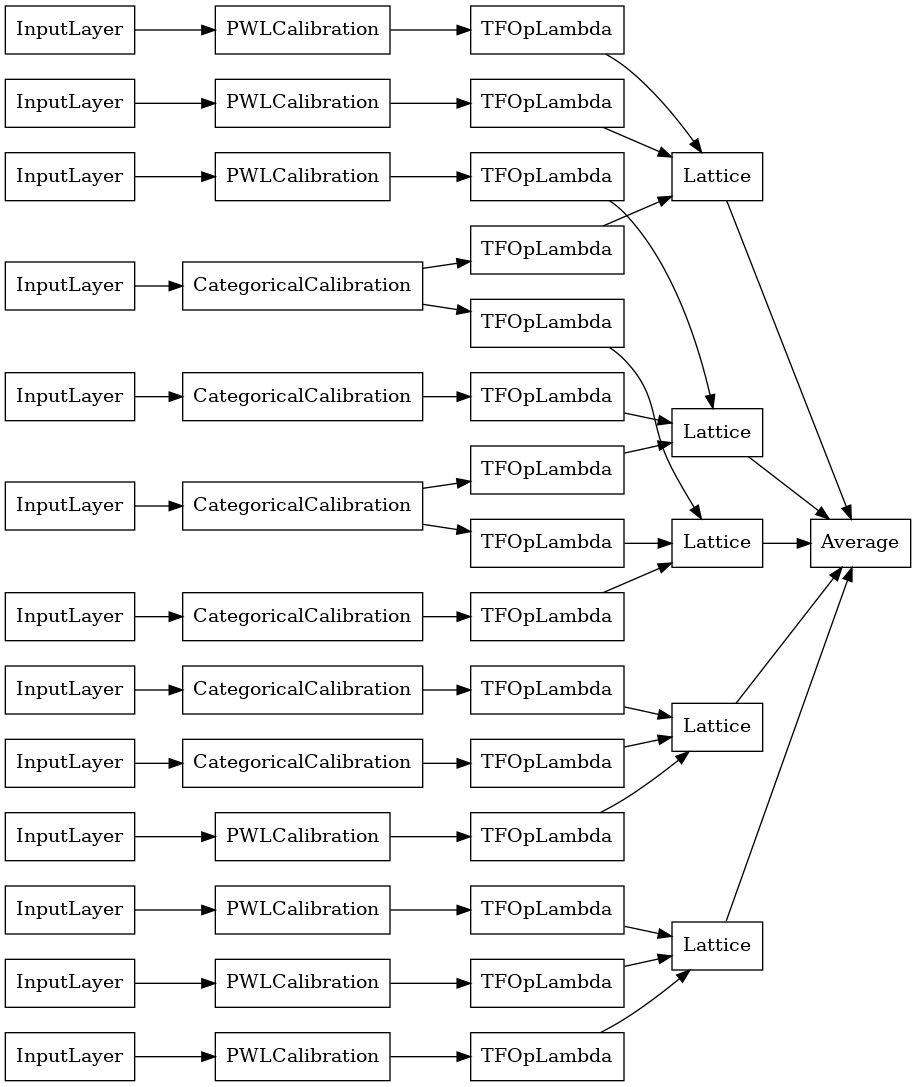

In [18]:
# This is a calibrated lattice ensemble model: inputs are calibrated, then
# combined non-linearly and averaged using multiple lattice layers.
explicit_ensemble_model_config = tfl.configs.CalibratedLatticeEnsembleConfig(
    feature_configs=feature_configs,
    lattices=[['trestbps', 'chol', 'ca'], ['fbs', 'restecg', 'thal'],
              ['fbs', 'cp', 'oldpeak'], ['exang', 'slope', 'thalach'],
              ['restecg', 'age', 'sex']],
    num_lattices=5,
    lattice_rank=3,
    output_min=min_label,
    output_max=max_label - numerical_error_epsilon,
    output_initialization=[min_label, max_label])
# A CalibratedLatticeEnsemble premade model constructed from the given
# model config.
explicit_ensemble_model = tfl.premade.CalibratedLatticeEnsemble(
    explicit_ensemble_model_config)
# Let's plot our model.
tf.keras.utils.plot_model(
    explicit_ensemble_model, show_layer_names=False, rankdir='LR')

이전과 마찬가지로 모델을 컴파일하고 적합하도록 맞추고 평가합니다.

In [19]:
explicit_ensemble_model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.AUC()],
    optimizer=tf.keras.optimizers.Adam(LEARNING_RATE))
explicit_ensemble_model.fit(
    train_xs, train_ys, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, verbose=False)
print('Test Set Evaluation...')
print(explicit_ensemble_model.evaluate(test_xs, test_ys))

Test Set Evaluation...


1/2 [==============>...............] - ETA: 0s - loss: 0.4186 - auc_2: 0.7436

2/2 [==============================] - 1s 6ms/step - loss: 0.4319 - auc_2: 0.8615


[0.431865930557251, 0.8615288734436035]


### 무작위 격자 앙상블

격자에 어떤 특성의 하위 집합을 제공할지 확실하지 않은 경우 각 격자에 대해 무작위의 특성 하위 집합을 사용해보는 옵션이 있습니다. 이 예제에서는 5개의 격자와 격자당 3개의 특성이 있는 보정된 격자 앙상블 모델을 만듭니다.

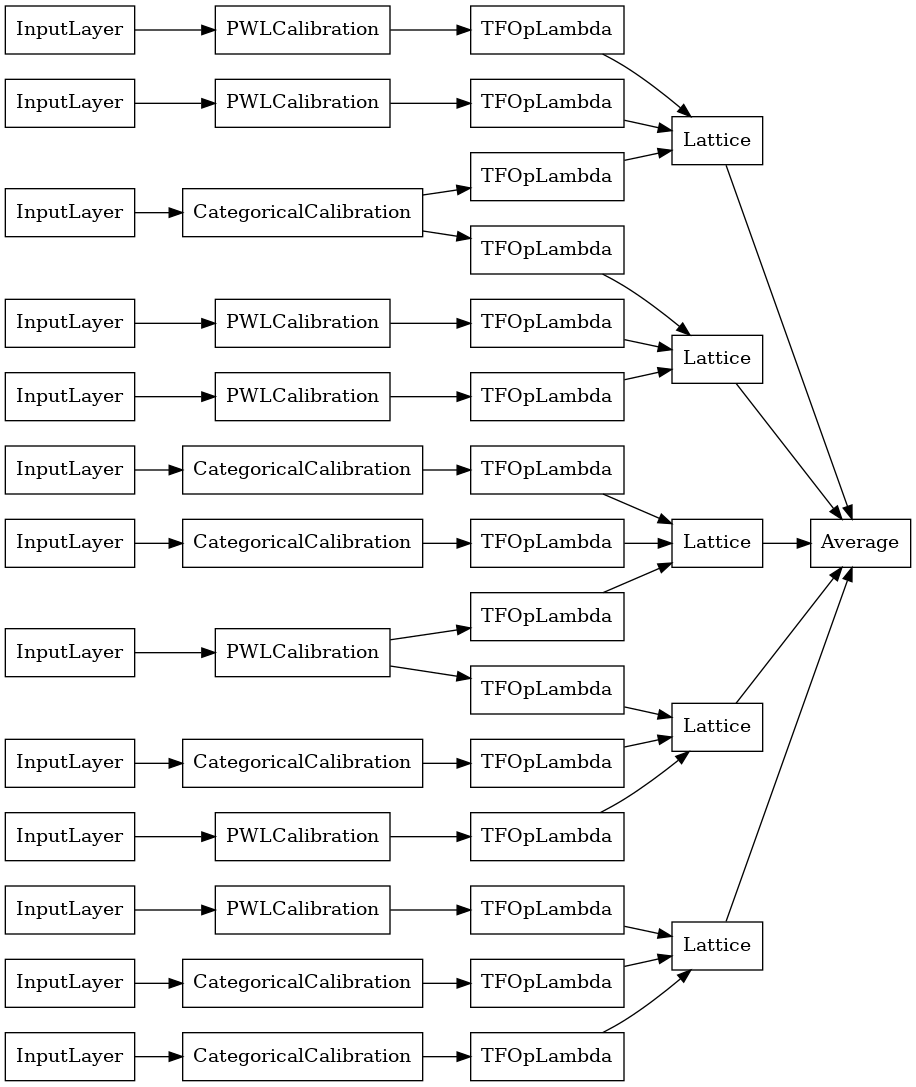

In [20]:
# This is a calibrated lattice ensemble model: inputs are calibrated, then
# combined non-linearly and averaged using multiple lattice layers.
random_ensemble_model_config = tfl.configs.CalibratedLatticeEnsembleConfig(
    feature_configs=feature_configs,
    lattices='random',
    num_lattices=5,
    lattice_rank=3,
    output_min=min_label,
    output_max=max_label - numerical_error_epsilon,
    output_initialization=[min_label, max_label],
    random_seed=42)
# Now we must set the random lattice structure and construct the model.
tfl.premade_lib.set_random_lattice_ensemble(random_ensemble_model_config)
# A CalibratedLatticeEnsemble premade model constructed from the given
# model config.
random_ensemble_model = tfl.premade.CalibratedLatticeEnsemble(
    random_ensemble_model_config)
# Let's plot our model.
tf.keras.utils.plot_model(
    random_ensemble_model, show_layer_names=False, rankdir='LR')

이전과 마찬가지로 모델을 컴파일하고 적합하도록 맞추고 평가합니다.

In [21]:
random_ensemble_model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.AUC()],
    optimizer=tf.keras.optimizers.Adam(LEARNING_RATE))
random_ensemble_model.fit(
    train_xs, train_ys, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, verbose=False)
print('Test Set Evaluation...')
print(random_ensemble_model.evaluate(test_xs, test_ys))

Test Set Evaluation...


1/2 [==============>...............] - ETA: 0s - loss: 0.3497 - auc_3: 0.8910

2/2 [==============================] - 1s 6ms/step - loss: 0.3928 - auc_3: 0.9217


[0.39279305934906006, 0.9216791987419128]


### RTL 레이어 무작위 격자 앙상블

무작위 격자 앙상블을 사용하는 경우 모델이 단일 `tfl.layers.RTL` 레이어를 사용하도록 지정할 수 있습니다. `tfl.layers.RTL`은 단조 제약 조건만 지원하며 모든 특성에 대해 같은 격자 크기를 가져야 하고 특성별 정규화가 없어야 합니다. `tfl.layers.RTL` 레이어를 사용하면 별도의 `tfl.layers.Lattice` 인스턴스를 사용하는 것보다 훨씬 더 큰 앙상블로 확장할 수 있습니다.

이 예제에서는 5개의 격자와 격자당 3개의 특성이 있는 보정된 격자 앙상블 모델을 만듭니다.

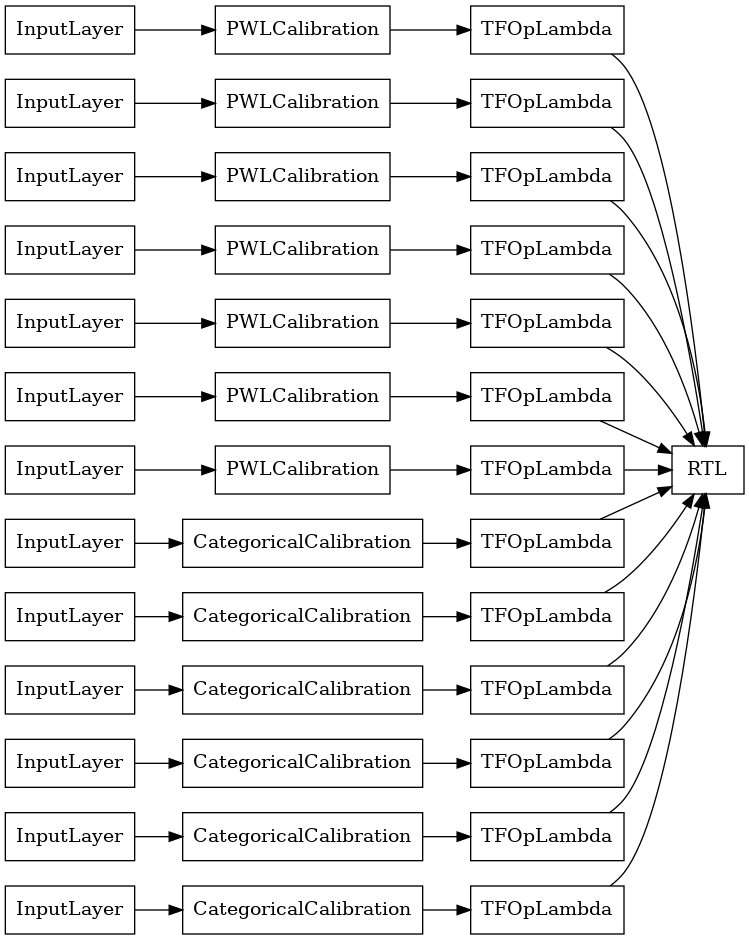

In [22]:
# Make sure our feature configs have the same lattice size, no per-feature
# regularization, and only monotonicity constraints.
rtl_layer_feature_configs = copy.deepcopy(feature_configs)
for feature_config in rtl_layer_feature_configs:
  feature_config.lattice_size = 2
  feature_config.unimodality = 'none'
  feature_config.reflects_trust_in = None
  feature_config.dominates = None
  feature_config.regularizer_configs = None
# This is a calibrated lattice ensemble model: inputs are calibrated, then
# combined non-linearly and averaged using multiple lattice layers.
rtl_layer_ensemble_model_config = tfl.configs.CalibratedLatticeEnsembleConfig(
    feature_configs=rtl_layer_feature_configs,
    lattices='rtl_layer',
    num_lattices=5,
    lattice_rank=3,
    output_min=min_label,
    output_max=max_label - numerical_error_epsilon,
    output_initialization=[min_label, max_label],
    random_seed=42)
# A CalibratedLatticeEnsemble premade model constructed from the given
# model config. Note that we do not have to specify the lattices by calling
# a helper function (like before with random) because the RTL Layer will take
# care of that for us.
rtl_layer_ensemble_model = tfl.premade.CalibratedLatticeEnsemble(
    rtl_layer_ensemble_model_config)
# Let's plot our model.
tf.keras.utils.plot_model(
    rtl_layer_ensemble_model, show_layer_names=False, rankdir='LR')

이전과 마찬가지로 모델을 컴파일하고 적합하도록 맞추고 평가합니다.

In [23]:
rtl_layer_ensemble_model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.AUC()],
    optimizer=tf.keras.optimizers.Adam(LEARNING_RATE))
rtl_layer_ensemble_model.fit(
    train_xs, train_ys, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, verbose=False)
print('Test Set Evaluation...')
print(rtl_layer_ensemble_model.evaluate(test_xs, test_ys))

Test Set Evaluation...


1/2 [==============>...............] - ETA: 0s - loss: 0.4396 - auc_4: 0.7724

2/2 [==============================] - 0s 5ms/step - loss: 0.4481 - auc_4: 0.8490


[0.4481201767921448, 0.8489974737167358]


### Crystal 격자 앙상블

사전 제작은 또한 [Crystal](https://papers.nips.cc/paper/6377-fast-and-flexible-monotonic-functions-with-ensembles-of-lattices) 이라는 휴리스틱 특성 배열 알고리즘을 제공합니다. Crystal 알고리즘을 사용하기 위해 먼저 쌍별 특성 상호 작용을 추정하는 사전 적합 모델을 훈련합니다. 그런 다음 더 많은 비선형 상호 작용이 있는 특성이 같은 격자에 있도록 최종 앙상블을 배열합니다.

사전 제작 라이브러리는 사전 적합 모델 구성을 구성하고 결정 구조를 추출하기 위한 도우미 함수를 제공합니다. 사전 적합 모델은 완전하게 훈련될 필요가 없으므로 몇 번의 epoch면 충분합니다.

이 예제에서는 5개의 격자와 격자당 3개의 특성이 있는 보정된 격자 앙상블 모델을 만듭니다.

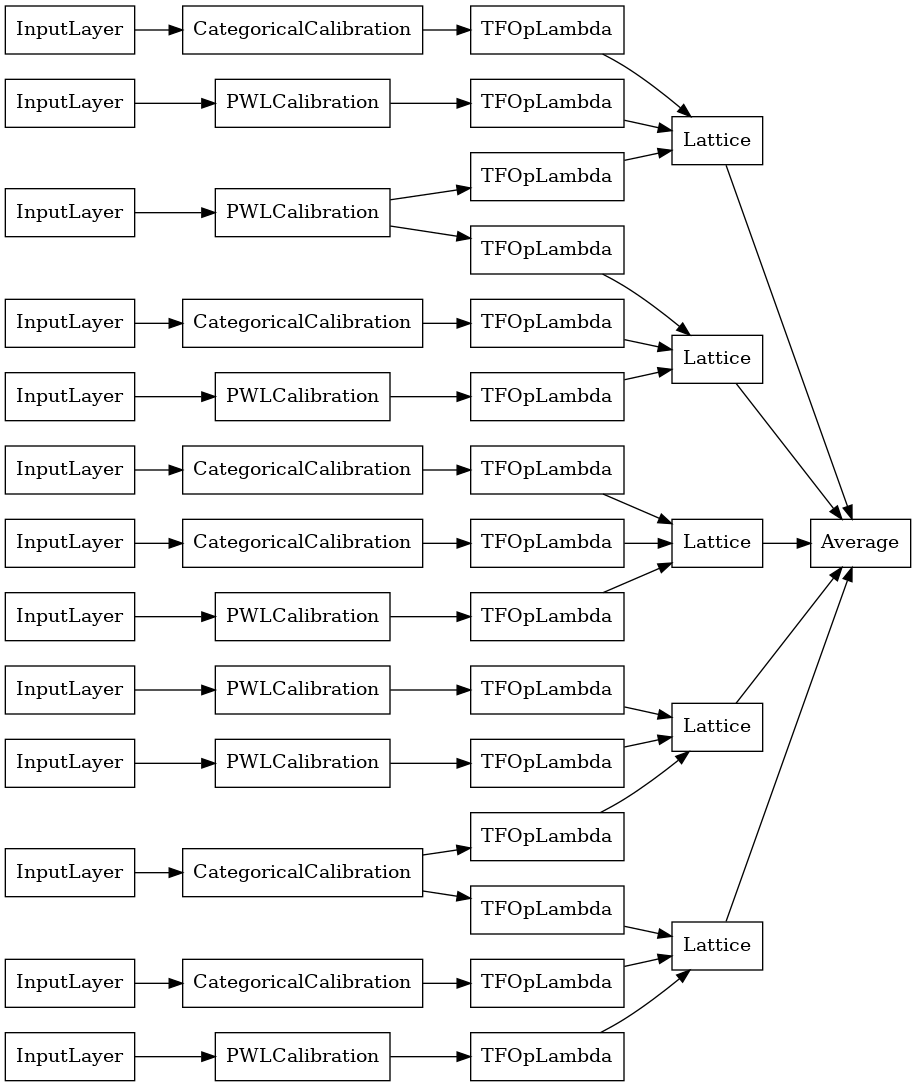

In [24]:
# This is a calibrated lattice ensemble model: inputs are calibrated, then
# combines non-linearly and averaged using multiple lattice layers.
crystals_ensemble_model_config = tfl.configs.CalibratedLatticeEnsembleConfig(
    feature_configs=feature_configs,
    lattices='crystals',
    num_lattices=5,
    lattice_rank=3,
    output_min=min_label,
    output_max=max_label - numerical_error_epsilon,
    output_initialization=[min_label, max_label],
    random_seed=42)
# Now that we have our model config, we can construct a prefitting model config.
prefitting_model_config = tfl.premade_lib.construct_prefitting_model_config(
    crystals_ensemble_model_config)
# A CalibratedLatticeEnsemble premade model constructed from the given
# prefitting model config.
prefitting_model = tfl.premade.CalibratedLatticeEnsemble(
    prefitting_model_config)
# We can compile and train our prefitting model as we like.
prefitting_model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(LEARNING_RATE))
prefitting_model.fit(
    train_xs,
    train_ys,
    epochs=PREFITTING_NUM_EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=False)
# Now that we have our trained prefitting model, we can extract the crystals.
tfl.premade_lib.set_crystals_lattice_ensemble(crystals_ensemble_model_config,
                                              prefitting_model_config,
                                              prefitting_model)
# A CalibratedLatticeEnsemble premade model constructed from the given
# model config.
crystals_ensemble_model = tfl.premade.CalibratedLatticeEnsemble(
    crystals_ensemble_model_config)
# Let's plot our model.
tf.keras.utils.plot_model(
    crystals_ensemble_model, show_layer_names=False, rankdir='LR')

이전과 마찬가지로 모델을 컴파일하고 적합하도록 맞추고 평가합니다.

In [25]:
crystals_ensemble_model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.AUC()],
    optimizer=tf.keras.optimizers.Adam(LEARNING_RATE))
crystals_ensemble_model.fit(
    train_xs, train_ys, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, verbose=False)
print('Test Set Evaluation...')
print(crystals_ensemble_model.evaluate(test_xs, test_ys))

Test Set Evaluation...


1/2 [==============>...............] - ETA: 0s - loss: 0.3706 - auc_5: 0.8269

2/2 [==============================] - 1s 6ms/step - loss: 0.4206 - auc_5: 0.8860


[0.42064717411994934, 0.8859649300575256]
